In [8]:
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set up the StatsBomb data loader
SBL = StatsBombLoader()

# View all available competitions
df_competitions = SBL.competitions()

In [13]:
# get all the seasons in the dataset for the FA Women's Super League, which the target competion
competition_seasons = df_competitions[df_competitions['competition_name'] == "FA Women's Super League"]
competition_seasons

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
15,90,37,FA Women's Super League,England,female,2020/2021
16,42,37,FA Women's Super League,England,female,2019/2020
17,4,37,FA Women's Super League,England,female,2018/2019


In [11]:
# Create a dataframe with all games from FA Women's Super League 2020/2021 season
df_games = SBL.games(competition_id=37, season_id=90).set_index("game_id")

In [29]:
df_games.head()

,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3775648,90,37,Regular Season,11,2021-02-28 15:00:00,2647,968,0,4,Poundland Bescot Stadium,Lisa Benn
3775609,90,37,Regular Season,13,2021-04-28 20:30:00,968,972,2,0,Meadow Park,Emily Heaslip
3775633,90,37,Regular Season,14,2021-02-06 13:30:00,2647,749,1,0,Poundland Bescot Stadium,Jane Simms
3775570,90,37,Regular Season,18,2021-03-28 13:30:00,965,967,0,5,Broadfield Stadium,Christina Hattersley
3775581,90,37,Regular Season,18,2021-03-28 15:30:00,971,2647,2,0,Kingsmeadow,Sarah Garratt


### Explore a single game

In [12]:
# for the chose match_id, get the teams involved, players and events

game_id = 3775648
df_teams = SBL.teams(game_id)
df_players = SBL.players(game_id)
df_events = SBL.events(game_id)

In [17]:
df_teams.head()

,team_id,team_name
0,2647,Aston Villa
1,968,Arsenal WFC


In [18]:
df_players.head()

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,3775648,2647,4657,Anita Amma Ankyewah Asante,Anita Asante,6,True,4,Center Back,93
1,3775648,2647,10102,Stine Larsen,None,9,True,24,Left Center Forward,93
2,3775648,2647,10193,Chloe Arthur,None,8,True,15,Left Center Midfield,93
3,3775648,2647,15557,Emma Follis,None,7,False,0,Substitute,17
4,3775648,2647,15565,Marisa Ewers,None,21,True,10,Center Defensive Midfield,93


In [19]:
df_events.head()

,game_id,event_id,period_id,team_id,player_id,type_id,type_name,index,timestamp,minute,...,team_name,duration,extra,related_events,player_name,position_id,position_name,location,under_pressure,counterpress
0,3775648,3ae5d153-60b6-4fb0-a4c3-7406eb19134b,1,2647,NaN,35,Starting XI,1,1900-01-01 00:00:00.000,0,...,Aston Villa,0.000000,"{'tactics': {'formation': 352, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
1,3775648,dd387270-fb96-4574-aba5-4817cd6de379,1,968,NaN,35,Starting XI,2,1900-01-01 00:00:00.000,0,...,Arsenal WFC,0.000000,"{'tactics': {'formation': 433, 'lineup': [{'pl...",[],NaN,NaN,NaN,NaN,False,False
2,3775648,1cae007e-b10b-4959-be1f-5b595313b72c,1,968,NaN,18,Half Start,3,1900-01-01 00:00:00.000,0,...,Arsenal WFC,0.000000,{},[02403d23-9d60-4754-a1d7-7143ce0cffd7],NaN,NaN,NaN,NaN,False,False
3,3775648,02403d23-9d60-4754-a1d7-7143ce0cffd7,1,2647,NaN,18,Half Start,4,1900-01-01 00:00:00.000,0,...,Aston Villa,0.000000,{},[1cae007e-b10b-4959-be1f-5b595313b72c],NaN,NaN,NaN,NaN,False,False
4,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,968,15623.0,30,Pass,5,1900-01-01 00:00:00.340,0,...,Arsenal WFC,0.311672,"{'pass': {'recipient': {'id': 15619, 'name': '...",[9288eded-34de-46e0-b7eb-9bd68af24b4a],Vivianne Miedema,21.0,Left Wing,"[61.0, 40.1]",False,False


In [17]:
home_team_id = df_games.at[game_id, "home_team_id"]
df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id)

In [21]:
df_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,0.0,968,15623.0,52.058824,33.655696,51.176471,35.549367,0,1,0,0
1,3775648,0cb83915-5393-49da-9ade-106c9ef6a51e,1,0.0,968,15619.0,51.176471,35.549367,53.558824,34.258228,21,1,0,1
2,3775648,edd39d4f-cbcf-428d-a6f6-80914c176414,1,0.0,968,15619.0,53.558824,34.258228,68.823529,33.483544,0,1,0,2
3,3775648,a281156d-530b-4cd5-90a7-e40004b135c3,1,1.0,968,10405.0,68.823529,33.483544,68.029412,34.516456,21,1,0,3
4,3775648,dac600a7-e892-4dd2-a0f6-f06547c7d4d9,1,2.0,968,10405.0,68.029412,34.516456,70.323529,18.678481,0,1,0,4


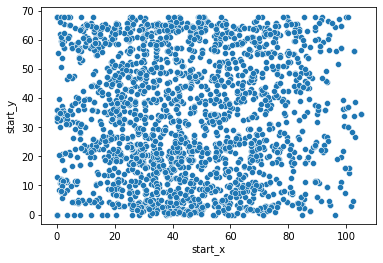

In [22]:
plt.figure()
sns.scatterplot(x=df_actions['start_x'], y=df_actions['start_y'])
plt.show()

In [16]:
df_actions = spadl.add_names(df_actions)
df_actions.head()

NameError: name 'df_actions' is not defined

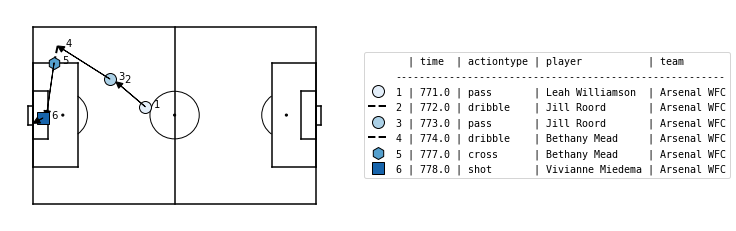

In [27]:
import matplotsoccer as mps

# Select relevant actions
df_actions_goal = df_actions.loc[1481 - 5: 1481]
# Replace result, actiontype and bodypart IDs by their corresponding name
df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False
)

In [15]:
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl

# 1. Load a set of actions to train the model on
actions = df_actions

# 2. Convert direction of play
# actions_ltr = pd.concat([
#   spadl.play_left_to_right(actions[game_id], game.home_team_id)
#   for game_id, game in df_games.iterrows()
# ])

actions = spadl.play_left_to_right(actions, home_team_id=home_team_id)

# 3. Train xT model
xTModel = xthreat.ExpectedThreat(l=16, w=12)
xTModel.fit(actions)

# 4. Rate ball-progressing actions
# xT should only be used to value actions that move the ball
# and that keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(actions)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

NameError: name 'df_actions' is not defined

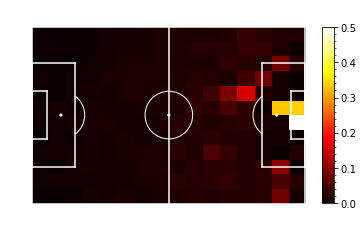

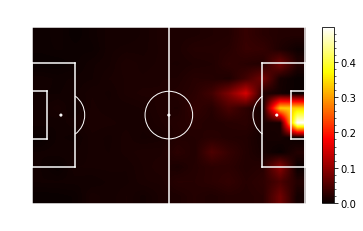

<AxesSubplot:>

In [31]:
# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

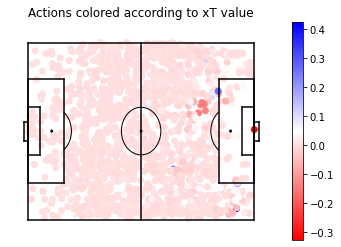

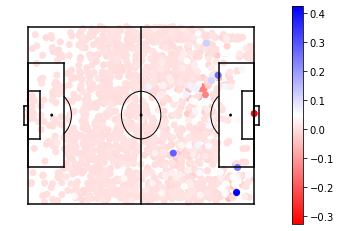

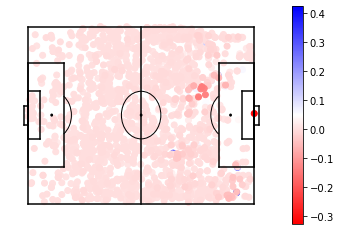

In [32]:
import matplotlib.pyplot as plt

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.title("Actions colored according to xT value")
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value", ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value", ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y, c=a.xT_value, cmap="bwr_r")
plt.colorbar()
plt.show()

In [33]:
import plotly.graph_objects as go

def visualize_surface_plots(xTModel):
    """ Visualizes the surface plot of each iteration of the model.

        See https://plot.ly/python/sliders/ and https://karun.in/blog/expected-threat.html#visualizing-xt
        NOTE: y-axis is mirrored in plotly.
    """
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2.25, y=-1, z=0.5),
    )

    max_z = np.around(xTModel.xT.max() + 0.05, decimals=1)

    layout = go.Layout(
        title="Expected Threat",
        autosize=True,
        width=500,
        height=500,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            camera=camera,
            aspectmode="auto",
            xaxis=dict(),
            yaxis=dict(),
            zaxis=dict(autorange=False, range=[0, max_z]),
        ),
    )

    fig = go.Figure(layout=layout)

    for i in xTModel.heatmaps:
        fig.add_trace(go.Surface(z=i))

    # Make last trace visible
    for i in range(len(fig.data) - 1):
        fig.data[i].visible = False
    fig.data[len(fig.data) - 1].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(method="restyle", args=["visible", [False] * len(fig.data)])
        step["args"][1][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [
        dict(
            active=(len(fig.data) - 1),
            currentvalue={"prefix": "Iteration: "},
            pad={"t": 50},
            steps=steps,
        )
    ]

    fig.update_layout(sliders=sliders)
    fig.show()
    
visualize_surface_plots(xTModel)

In [42]:
from socceraction.vaep import VAEP
from tqdm import tqdm

VAEP_model = VAEP(nb_prev_actions=5)

# compute features and labels for each game
all_features, all_labels, all_actions = [], [], []
for game_id, game in tqdm(list(df_games.iterrows())):
    
    # load the game's events
    game_events = SBL.events(game_id)
    
    # convert the events to actions
    game_home_team_id = df_games.at[game_id, "home_team_id"]
    game_actions = spadl.statsbomb.convert_to_actions(game_events, game_home_team_id)
    
    # compute features and labels
    all_actions.append(game_actions)
    all_features.append(VAEP_model.compute_features(game, game_actions))
    all_labels.append(VAEP_model.compute_labels(game, game_actions))

# combine all features and labels in a single dataframe
all_actions = pd.concat(all_actions)
all_features = pd.concat(all_features)
all_labels = pd.concat(all_labels)

# fit the model
VAEP_model.fit(all_features, all_labels)

100%|██████████| 131/131 [04:00<00:00,  1.84s/it]


[0]	validation_0-auc:0.74326
[1]	validation_0-auc:0.74802
[2]	validation_0-auc:0.76615
[3]	validation_0-auc:0.76662
[4]	validation_0-auc:0.78157
[5]	validation_0-auc:0.79640
[6]	validation_0-auc:0.79509
[7]	validation_0-auc:0.79954
[8]	validation_0-auc:0.80041
[9]	validation_0-auc:0.80253
[10]	validation_0-auc:0.80256
[11]	validation_0-auc:0.80665
[12]	validation_0-auc:0.80744
[13]	validation_0-auc:0.80985
[14]	validation_0-auc:0.81076
[15]	validation_0-auc:0.81197
[16]	validation_0-auc:0.81561
[17]	validation_0-auc:0.81530
[18]	validation_0-auc:0.81632
[19]	validation_0-auc:0.81803
[20]	validation_0-auc:0.82028
[21]	validation_0-auc:0.82193
[22]	validation_0-auc:0.82403
[23]	validation_0-auc:0.82535
[24]	validation_0-auc:0.82627
[25]	validation_0-auc:0.82698
[26]	validation_0-auc:0.82700
[27]	validation_0-auc:0.82955
[28]	validation_0-auc:0.83036
[29]	validation_0-auc:0.83101
[30]	validation_0-auc:0.83130
[31]	validation_0-auc:0.83249
[32]	validation_0-auc:0.83260
[33]	validation_0-au

In [43]:
all_actions.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id
0,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,0.0,968,15623.0,52.058824,33.655696,51.176471,35.549367,0,1,0,0
1,3775648,0cb83915-5393-49da-9ade-106c9ef6a51e,1,0.0,968,15619.0,51.176471,35.549367,53.558824,34.258228,21,1,0,1
2,3775648,edd39d4f-cbcf-428d-a6f6-80914c176414,1,0.0,968,15619.0,53.558824,34.258228,68.823529,33.483544,0,1,0,2
3,3775648,a281156d-530b-4cd5-90a7-e40004b135c3,1,1.0,968,10405.0,68.823529,33.483544,68.029412,34.516456,21,1,0,3
4,3775648,dac600a7-e892-4dd2-a0f6-f06547c7d4d9,1,2.0,968,10405.0,68.029412,34.516456,70.323529,18.678481,0,1,0,4


## Creating new Features

In [34]:
df_actions['x_dif'] = (df_actions['end_x'] - df_actions['start_x'])
df_actions['y_dif'] = (df_actions['end_y'] - df_actions['start_y'])

df_actions[['x_dif', 'y_dif']].head()

,x_dif,y_dif
0,-0.882353,1.893671
1,2.382353,-1.291139
2,15.264706,-0.774684
3,-0.794118,1.032911
4,2.294118,-15.837975


<Figure size 432x288 with 0 Axes>

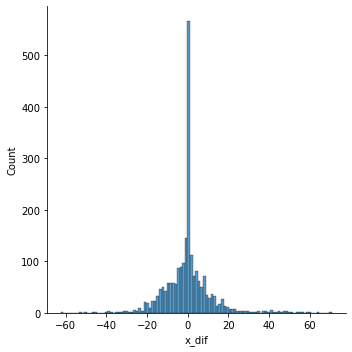

In [35]:
plt.figure()
sns.displot(df_actions['x_dif'])
plt.show()

In [36]:
df_actions_zones = df_actions.copy()
df_actions_zones = spadl.play_left_to_right(df_actions_zones, home_team_id==home_team_id) 

In [37]:
df_actions_zones.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,x_dif,y_dif
0,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,0.0,968,15623.0,52.941176,34.344304,53.823529,32.450633,0,1,0,0,pass,success,foot,-0.882353,1.893671
1,3775648,0cb83915-5393-49da-9ade-106c9ef6a51e,1,0.0,968,15619.0,53.823529,32.450633,51.441176,33.741772,21,1,0,1,dribble,success,foot,2.382353,-1.291139
2,3775648,edd39d4f-cbcf-428d-a6f6-80914c176414,1,0.0,968,15619.0,51.441176,33.741772,36.176471,34.516456,0,1,0,2,pass,success,foot,15.264706,-0.774684
3,3775648,a281156d-530b-4cd5-90a7-e40004b135c3,1,1.0,968,10405.0,36.176471,34.516456,36.970588,33.483544,21,1,0,3,dribble,success,foot,-0.794118,1.032911
4,3775648,dac600a7-e892-4dd2-a0f6-f06547c7d4d9,1,2.0,968,10405.0,36.970588,33.483544,34.676471,49.321519,0,1,0,4,pass,success,foot,2.294118,-15.837975


In [38]:
df_actions_zones.columns

Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'x_dif', 'y_dif'],
      dtype='object')

In [39]:
zones = []

for i, row in df_actions_zones.iterrows():
    if ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_1')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_2')
    elif ((row['start_x'] >=0) & (row['start_x'] < 35)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_3')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_4')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_5')
    elif ((row['start_x'] >=35) & (row['start_x'] < 70)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_6')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=0) & (row['start_y'] < 23)):
        zones.append('zone_7')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=23) & (row['start_y'] < 46)):
        zones.append('zone_8')
    elif ((row['start_x'] >=70) & (row['start_x'] <= 105)) & ((row['start_y']>=46) & (row['start_y'] <= 69)):
        zones.append('zone_9')
    else:
        zones.append('no_zone')

df_actions_zones['start_pitch_zone'] = zones
# df_actions_zones['start_pitch_zone'] = df_actions_zones[['start_x', 'start_y']].apply(lambda x: )

In [40]:
#We're working with a large dataset and may need to view columns
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [41]:
action_zone_count = df_actions_zones[['type_name','start_pitch_zone']].groupby(['type_name','start_pitch_zone']).value_counts().reset_index()

In [42]:
action_zone_count.rename({0: 'count'}, axis='columns', inplace=True)

In [43]:
action_zone_count

,type_name,start_pitch_zone,count
0,bad_touch,zone_1,4
1,bad_touch,zone_2,1
2,bad_touch,zone_3,2
3,bad_touch,zone_4,4
4,bad_touch,zone_6,2
5,bad_touch,zone_7,7
6,bad_touch,zone_8,6
7,bad_touch,zone_9,2
8,clearance,zone_1,2
9,clearance,zone_2,1


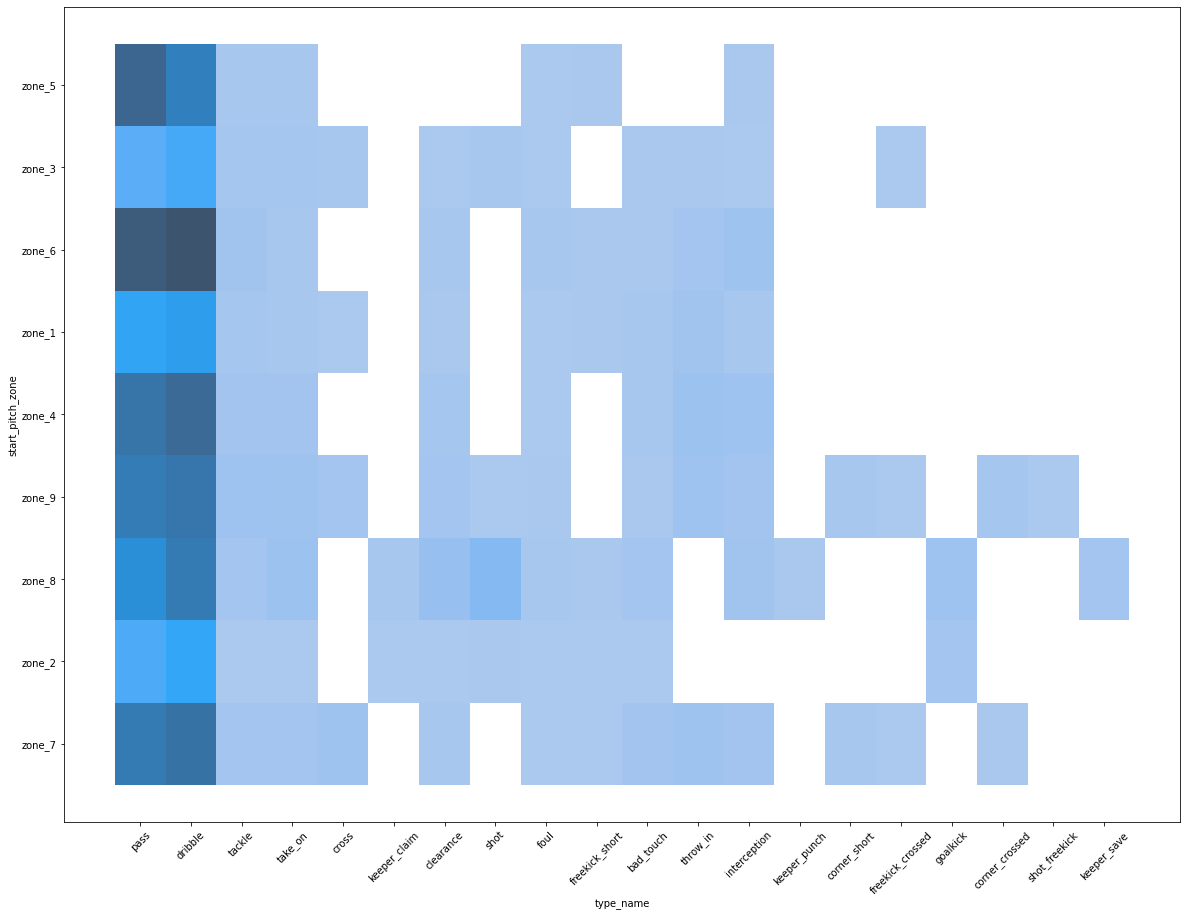

In [44]:
plt.figure(figsize=[20, 15])
sns.histplot(data=df_actions_zones[['start_pitch_zone', 'type_name']], x='type_name', y='start_pitch_zone')
plt.xticks(rotation=45)
plt.show()

### Features to add in

**Notebooks:**

- Single match exploration and variables/data discovery
- Data prep across seasons - build main dataset and split into test/validate/test
- Statistical testing inputs against targets
- Clustering player targets, predicting next actions, validating and testing 
- Predicting transfers


**Input Features:**

- 'game_id' - maybe (might need it to generate features, but drop before feeding model)
- 'original_event_id' - maybe
- 'period_id' 
- 'time_seconds' - maybe
- 'team_id',   
- 'player_id', 
- 'start_x', 
- 'start_y', 


These would not feed into the model, as they wouldnt be known yet for the line I am running prediction on - they should be represented in the n-x columns only as part of the previous moves. 

```
- 'end_x', 
- 'end_y',
- 'type_id',
- 'result_id', 
- 'bodypart_id', 
- 'action_id', 
- 'type_name', 
- 'result_name',
- 'bodypart_name', 
```


**To add:**
- Distance X
- Distance Y 
- 'start_pitch_zone'
- end_pitch_zone
- opponent
- home (how would this work when getting predictions? and when training)
- away

**For actions n-5:**
(if using a dataset with multiple matches, make sure they are from the same game)
- Prev_action_n-x_x_distance
- Prev_action_n-x_y_distance
- n-x_same_team
- n-x_same_player
- n-x_x_direction 
- n-x_y_direction
- n-x_action
- n-x_pitch_zone

**Target output:**

- Type of action 
- Next Zone

```some of these will need to be dummied```

**Football Scoring Metrics**
- xT per action 
- VAEP 
- aggregates at player level

Then swap the player ID for the player that we'd want to swap in to create a prediction dataset. 
(see if there is a transfer within the datast we could use as validation of the model)

- use the first 2 seasons for train and validate and the last season for test 
- predict the actions of players that had a transfer between season 2 and 3 - to test how the prediction does 

Each line of data should be standalone, rather than sequential - transforming sequential - time series type data - into non-sequential data

Then xT and VEAP output

In [45]:
df_actions_zones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 0 to 2287
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_id            2288 non-null   int64  
 1   original_event_id  2240 non-null   object 
 2   period_id          2288 non-null   int64  
 3   time_seconds       2288 non-null   float64
 4   team_id            2288 non-null   int64  
 5   player_id          2288 non-null   float64
 6   start_x            2288 non-null   float64
 7   start_y            2288 non-null   float64
 8   end_x              2288 non-null   float64
 9   end_y              2288 non-null   float64
 10  type_id            2288 non-null   int64  
 11  result_id          2288 non-null   int64  
 12  bodypart_id        2288 non-null   int64  
 13  action_id          2288 non-null   int64  
 14  type_name          2288 non-null   object 
 15  result_name        2288 non-null   object 
 16  bodypart_name      2288 

In [46]:
end_zones = []

for i, row in df_actions_zones.iterrows():
    if ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_1')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_2')
    elif ((row['end_x'] >=0) & (row['end_x'] < 35)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_3')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_4')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_5')
    elif ((row['end_x'] >=35) & (row['end_x'] < 70)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_6')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=0) & (row['end_y'] < 23)):
        end_zones.append('zone_7')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=23) & (row['end_y'] < 46)):
        end_zones.append('zone_8')
    elif ((row['end_x'] >=70) & (row['end_x'] <= 105)) & ((row['end_y']>=46) & (row['end_y'] <= 69)):
        end_zones.append('zone_9')
    else:
        end_zones.append('no_zone')

df_actions_zones['end_pitch_zone'] = end_zones

In [47]:
df_actions_zones['start_pitch_zone'].value_counts()

zone_6    377
zone_4    317
zone_8    308
zone_7    306
zone_9    305
zone_5    273
zone_1    159
zone_2    122
zone_3    121
Name: start_pitch_zone, dtype: int64

In [48]:
df_actions_zones['end_pitch_zone'].value_counts()

zone_6    375
zone_4    320
zone_8    316
zone_9    304
zone_7    304
zone_5    271
zone_1    159
zone_2    120
zone_3    119
Name: end_pitch_zone, dtype: int64

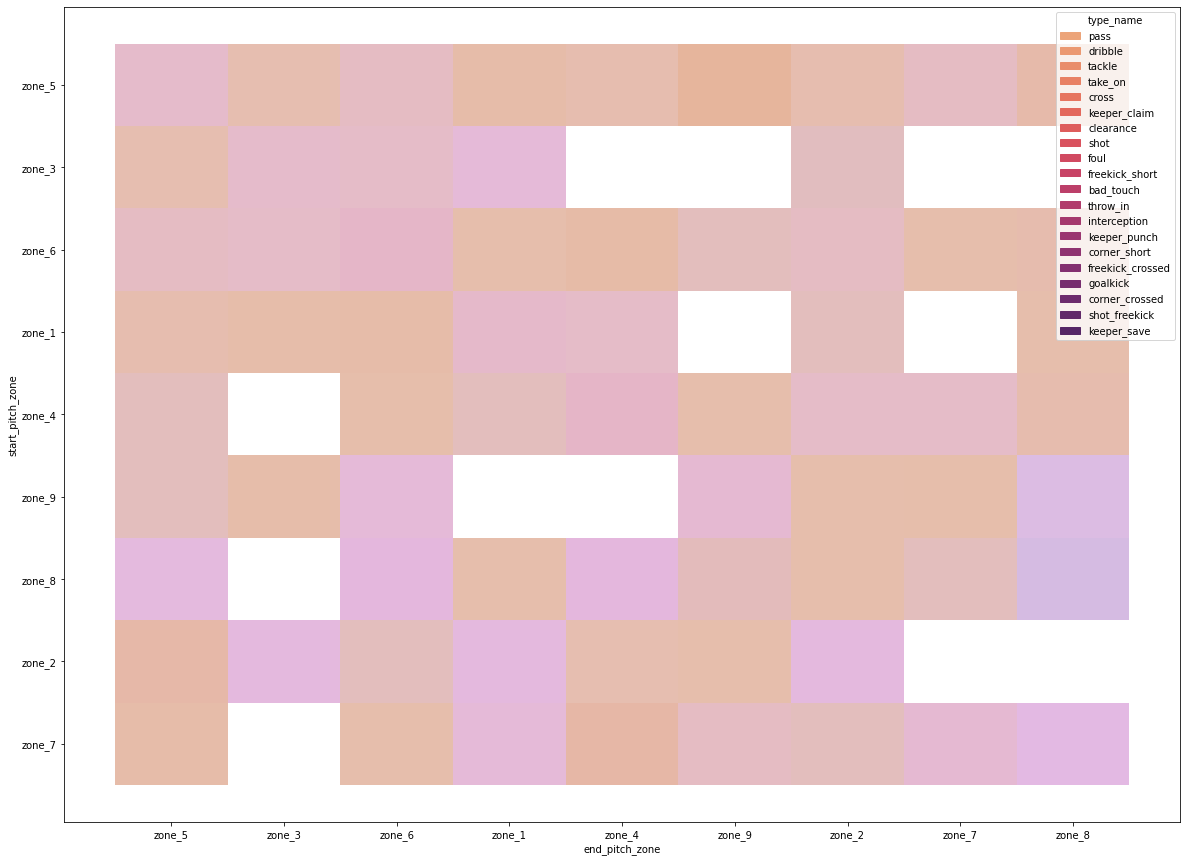

In [49]:
plt.figure(figsize=[20,15])
sns.histplot(data=df_actions_zones, x='end_pitch_zone',y='start_pitch_zone',hue='type_name', stat="count", palette='flare')
plt.show()

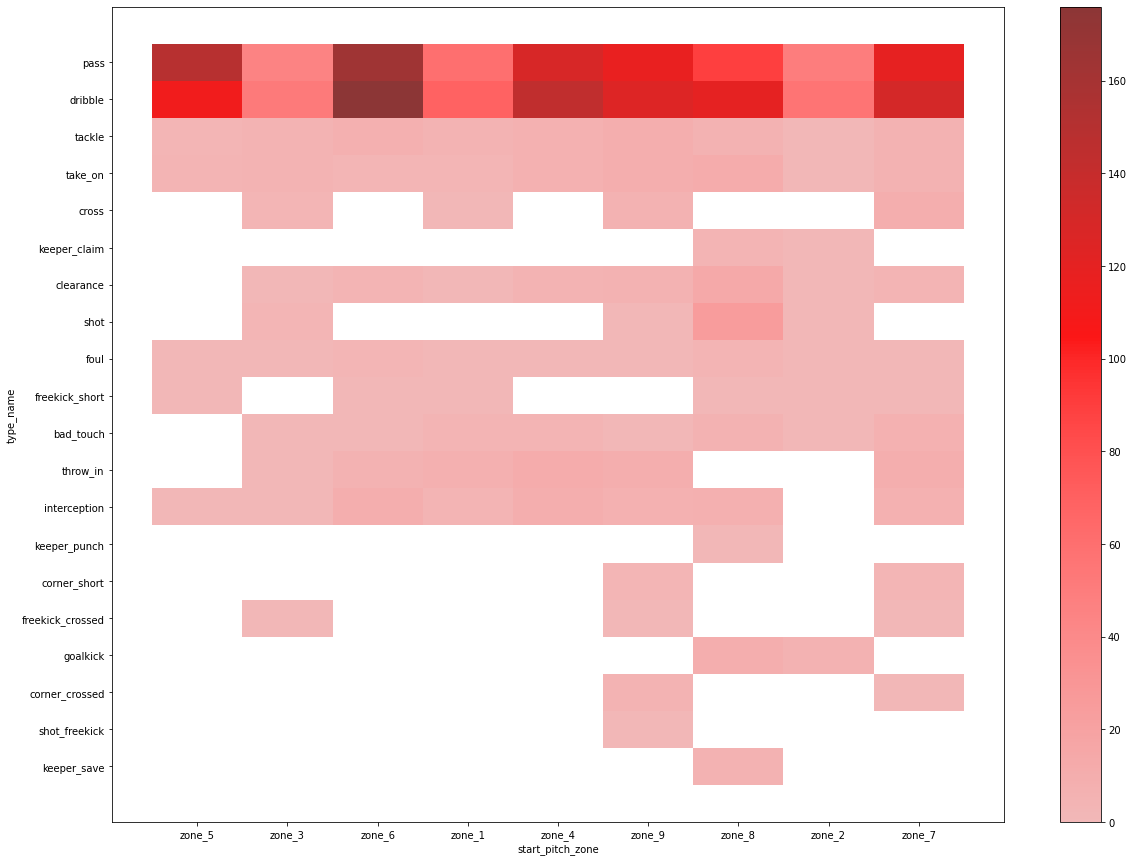

In [50]:
plt.figure(figsize=[20,15])
sns.histplot(data=df_actions_zones, x='start_pitch_zone',y='type_name', stat="count", cbar=True, color='red')
plt.show()

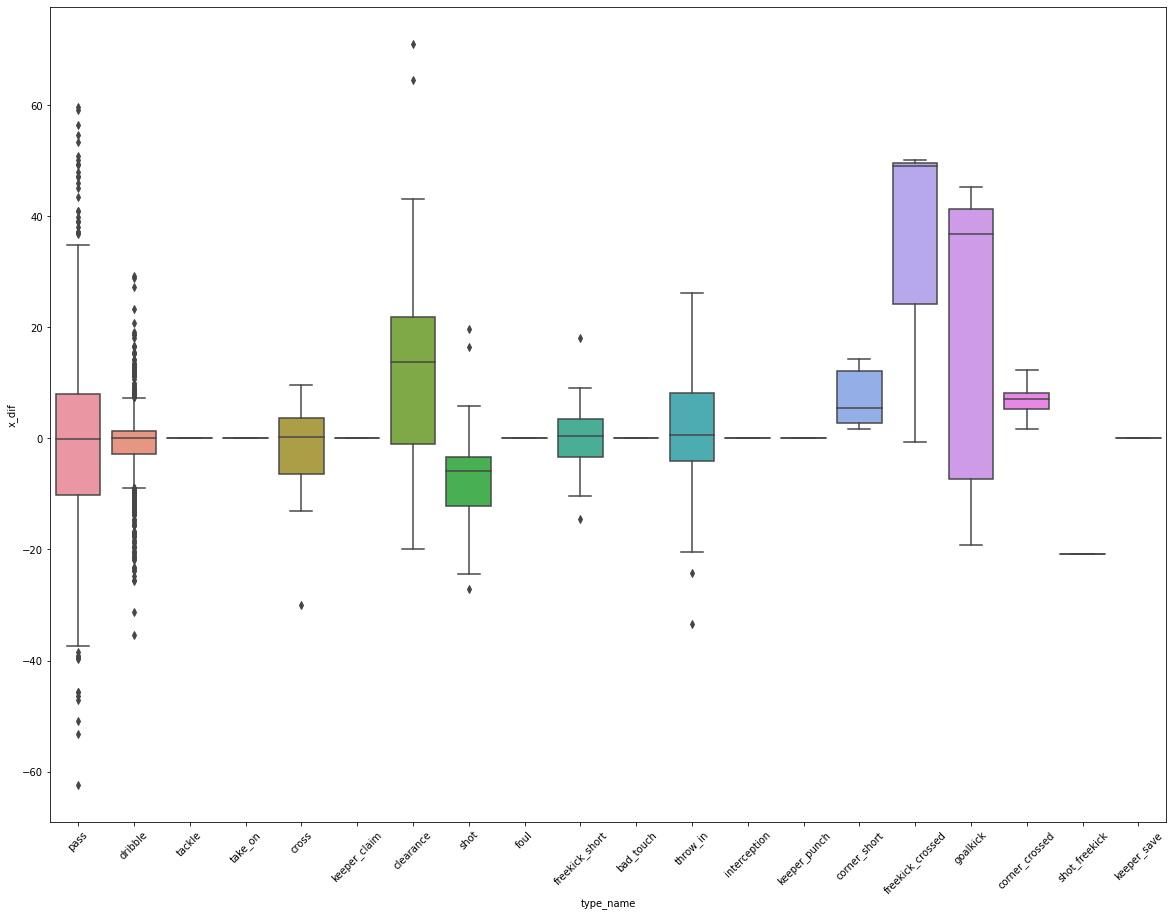

In [51]:
plt.figure(figsize=(20,15))
sns.boxplot(y=df_actions_zones['x_dif'], x=df_actions_zones['type_name'])
plt.xticks(rotation=45)
plt.show()

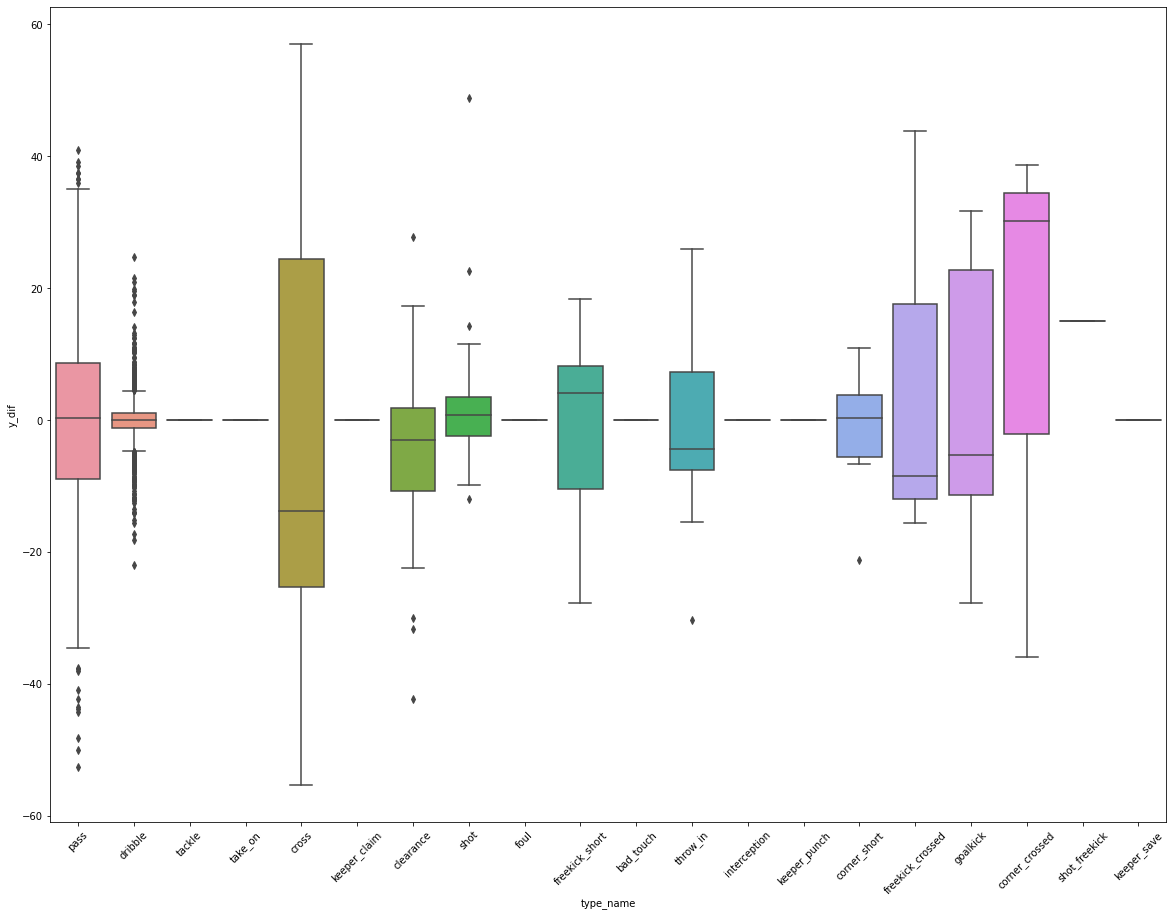

In [52]:
plt.figure(figsize=(20,15))
sns.boxplot(y=df_actions_zones['y_dif'], x=df_actions_zones['type_name'])
plt.xticks(rotation=45)
plt.show()

In [53]:
#Opposition 

# when pulling together the whole match list, unique_team will need to be refactored to update for each match
unique_teams = list(df_actions_zones['team_id'].unique())
df_actions_zones['opponent_id'] = [unique_teams[1] if 
    unique_teams.index(row['team_id']) == 0 else unique_teams[0] for i, row in df_actions_zones.iterrows()]

In [54]:
df_games.head()

,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3775648,90,37,Regular Season,11,2021-02-28 15:00:00,2647,968,0,4,Poundland Bescot Stadium,Lisa Benn
3775609,90,37,Regular Season,13,2021-04-28 20:30:00,968,972,2,0,Meadow Park,Emily Heaslip
3775633,90,37,Regular Season,14,2021-02-06 13:30:00,2647,749,1,0,Poundland Bescot Stadium,Jane Simms
3775570,90,37,Regular Season,18,2021-03-28 13:30:00,965,967,0,5,Broadfield Stadium,Christina Hattersley
3775581,90,37,Regular Season,18,2021-03-28 15:30:00,971,2647,2,0,Kingsmeadow,Sarah Garratt


In [55]:
df_actions_zones.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,x_dif,y_dif,start_pitch_zone,end_pitch_zone,opponent_id
0,3775648,d062f895-1e3c-4fff-9937-fa3c81408bf7,1,0.0,968,15623.0,52.941176,34.344304,53.823529,32.450633,0,1,0,0,pass,success,foot,-0.882353,1.893671,zone_5,zone_5,2647
1,3775648,0cb83915-5393-49da-9ade-106c9ef6a51e,1,0.0,968,15619.0,53.823529,32.450633,51.441176,33.741772,21,1,0,1,dribble,success,foot,2.382353,-1.291139,zone_5,zone_5,2647
2,3775648,edd39d4f-cbcf-428d-a6f6-80914c176414,1,0.0,968,15619.0,51.441176,33.741772,36.176471,34.516456,0,1,0,2,pass,success,foot,15.264706,-0.774684,zone_5,zone_5,2647
3,3775648,a281156d-530b-4cd5-90a7-e40004b135c3,1,1.0,968,10405.0,36.176471,34.516456,36.970588,33.483544,21,1,0,3,dribble,success,foot,-0.794118,1.032911,zone_5,zone_5,2647
4,3775648,dac600a7-e892-4dd2-a0f6-f06547c7d4d9,1,2.0,968,10405.0,36.970588,33.483544,34.676471,49.321519,0,1,0,4,pass,success,foot,2.294118,-15.837975,zone_5,zone_3,2647


In [59]:
# Home or Away

df_actions_zones['home'] = [1 if np.array(df_games[df_games.index == row['game_id']]['home_team_id'] == row['team_id'])[0] else 0 for i, row in df_actions_zones.iterrows()]
df_actions_zones['home'].value_counts()

0    1695
1     593
Name: home, dtype: int64

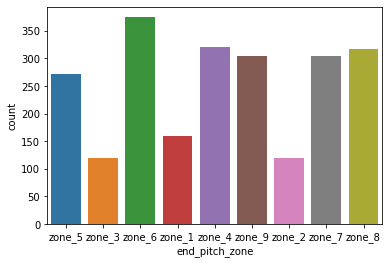

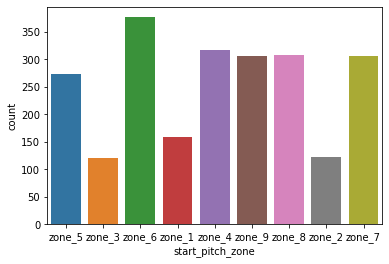

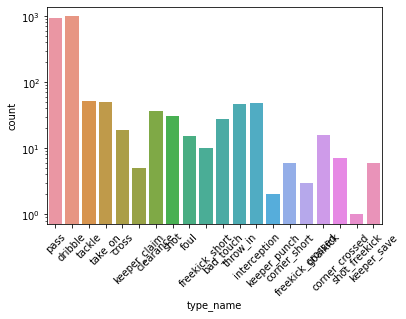

In [60]:
plt.figure()
sns.countplot(x=df_actions_zones['end_pitch_zone'])
plt.figure()
sns.countplot(x=df_actions_zones['start_pitch_zone'])
plt.figure()
sns.countplot(x=df_actions_zones['type_name'])
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

In [63]:
for n in range(1,6):
    df_actions_zones[f'n-{n}_x_distance'] = [row['x_dif'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_y_distance'] = [row['y_dif'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_same_team'] = df_actions_zones.team_id.eq(df_actions_zones.team_id.shift(n))
    df_actions_zones[f'n-{n}_same_player'] = df_actions_zones.player_id.eq(df_actions_zones.player_id.shift(n))
    df_actions_zones[f'n-{n}_x_fwd_direction'] = [1 if row['x_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_y_lft_right_direction'] = [1 if row['y_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_start_pitch_zone'] = [row['start_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_end_pitch_zone'] = [row['end_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_start_x'] = [row['start_x'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_start_y'] = [row['start_y'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_end_x'] = [row['end_x'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_end_y'] = [row['end_y'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_type_name'] = [row['type_name'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_result_name'] = [row['result_name'] for i, row in df_actions_zones.shift(n).iterrows()]
    df_actions_zones[f'n-{n}_bodypart_name'] = [row['bodypart_name'] for i, row in df_actions_zones.shift(n).iterrows()]


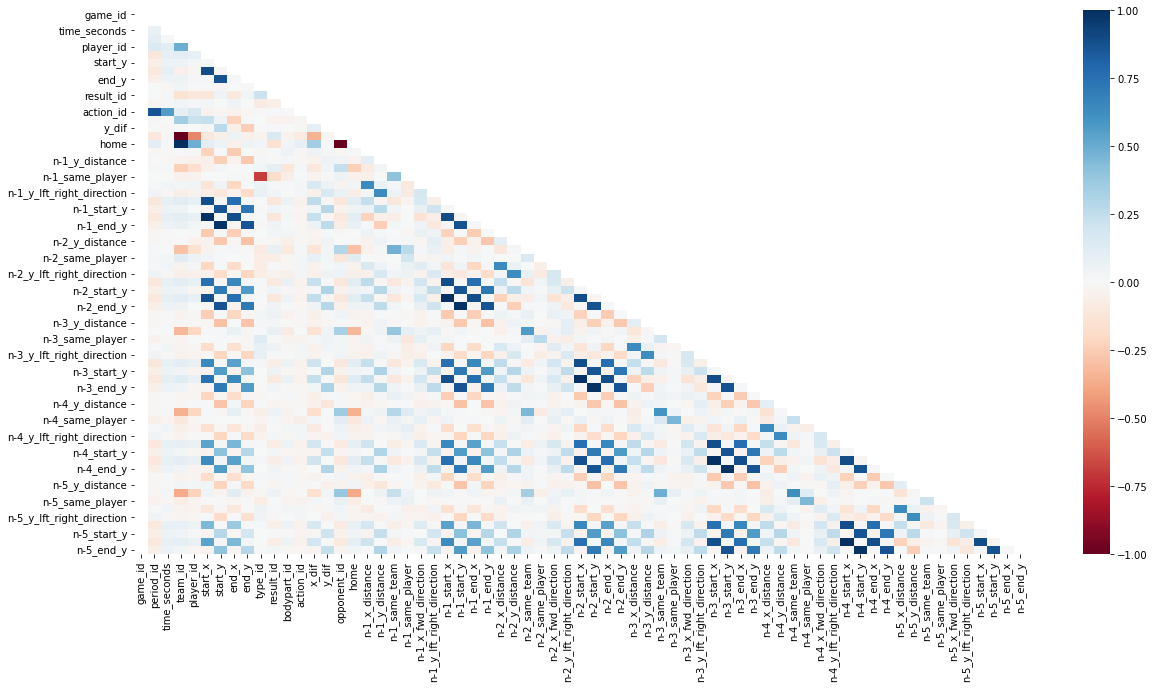

In [66]:
# find the correlation between the variables
corr = df_actions_zones.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()

In [67]:
# from scipy import stats 
# data = []
# for column in corr:
#     data.append(stats.pearsonr(df_actions_zones['end_x'], df_actions_zones[column]))

# num_col_corr = pd.DataFrame(data, index=corr.columns, columns=['Correlation', 'P_value'])
# num_col_corr.style.background_gradient(cmap='Oranges')

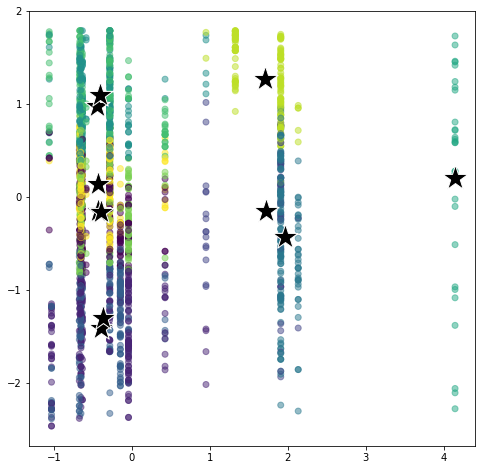

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_actions_zones[['player_id', 'start_x', 'start_y']]

ss = StandardScaler()

X = ss.fit_transform(X)

# Instantiate
k_means_model_2= KMeans(n_clusters=11)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()